# Neal, 2000を読んで分かるノンパラベイズ



In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

np.random.seed(0)

## 2. Dirichlet Process Mixture Models

Dirichlet Process による混合モデルです.

$$
\begin{eqnarray}
y_i \mid \theta_i &\sim& F\left( \theta_i \right) \\
\theta_i \mid G &\sim& G \tag{2.1} \\
G &\sim& \operatorname{DP} \left( G_0, \alpha \right)
\end{eqnarray}
$$

こんな風に書いている人もいる.

$$
\begin{eqnarray}
y_i &\sim& F\left( \cdot  \mid \theta_i \right), \; \forall i=1,...,N. \\
\theta_i  &\sim& G \\
G &\sim& \operatorname{DP} \left( \alpha G_0 \right)
\end{eqnarray}
$$



$ G $ は基底分布 $G_0$ とconcentration parameter $ \alpha $ に従う離散分布, $ \theta_i $は $ G $ に従う分布パラメータ, つまり $ G $ の 要素のどれか, $ F $ は $ \theta_i$ をパラメータとする分布.



$$
\begin{eqnarray}
\theta_i \mid \theta_{1,\;2,\;...,\;i-1} 
&\sim&
    \frac {1} {i - 1 + \alpha}
    \sum_{j=1}^{i-1} \delta \left( \theta_j \right)
    + \frac {\alpha} {i - 1 + \alpha} G_0
    \tag{2.2} \\
\end{eqnarray}
$$

これは下の混合モデルで $ K \to \infty $ したのと同じ, であるらしい


$$
\begin{eqnarray}
y_i \mid c_i, \boldsymbol \phi &\sim& F\left( \phi_{c_{i}} \right) \\
c_i  \mid \boldsymbol p&\sim& \operatorname {Discrete} \left(p_1, p_2, ..., p_K \right) \tag{2.3} \\
\phi_{c} &\sim& G_0 \\
\boldsymbol p &\sim& \operatorname {Dirichlet} \left(\frac {\alpha} {K},\frac {\alpha} {K}, ... , \frac {\alpha} {K} \right)
\end{eqnarray}
$$

実際に考えてみる.

$(2.3)$ は隠れ変数 $c_i$ を用いた混合比 $ \boldsymbol p $ の混合モデルである. $ G_0 $ は分布パラメータの事前分布である.

また, [Dirichelt分布からのサンプリング](https://en.wikipedia.org/wiki/Dirichlet_distribution#Random_number_generation)は以下で表される.


$$
\begin{eqnarray}
p\left(c_i \mid c_1, c_2, ..., c_{i-1} \right)
&=&
    p\left( c_1, ...,c_{i-1} , c_i = c \right) / p\left( c_1, ...,c_{i-1} \right) \tag {2.4}\\
&=&
    \frac
    {
        \int p_{c_1} ... p_{c_{i-1}}p_{c_{i}}
        \Gamma(\alpha) \Gamma(\alpha)^{-K}...p_1^{\alpha/K-1}p_K^{\alpha/K-1}
        \operatorname d\boldsymbol p
    }
    {
        \int p_{c_1} ... p_{c_{i-1}}
        \Gamma(\alpha) \Gamma(\alpha)^{-K}...p_1^{\alpha/K-1}p_K^{\alpha/K-1}
        \operatorname d\boldsymbol p
    } \tag {2.5} \\
&=&
    \frac {n_{i, c} + \alpha / K }{i-1+\alpha} \tag{2.6}
\end{eqnarray}
$$

これが解けない.

In [12]:
sp.stats.dirichlet.mean([9, 1])
sp.stats.dirichlet.pdf([0.9, 0.1], [9, 1])
sp.stats.dirichlet.rvs([1, 1], 10000).mean(axis=0)

array([0.5021903, 0.4978097])

SBPによる混合比と分布パラメータのサンプリングの例, クラスタ数を制限している.

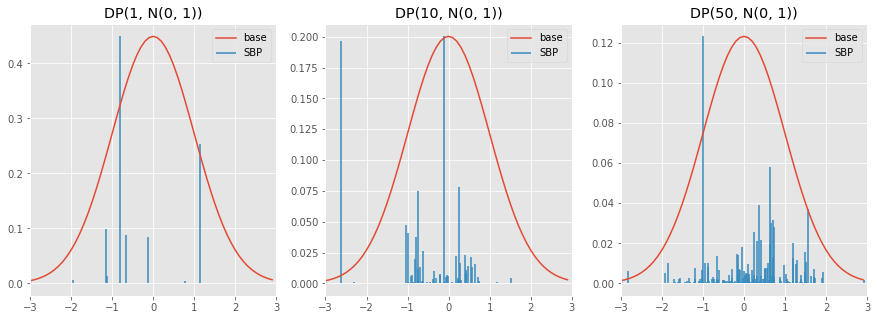

In [2]:
# Stick Breaking Process(SBP)
def stick_breaking_process(a, K=200):
    D0 = sp.stats.norm
    beta = sp.stats.beta.rvs(1, a, size=K)
    w = np.empty_like(beta)
    w[0] = beta[0]
    w[1:] = beta[1:] * (1 - beta[:-1]).cumprod()
    return D0.rvs(size=K), w

a = np.array([1, 10, 50])
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, ax in enumerate(axes):
    v, p = stick_breaking_process(a[i])
    ax.vlines(v, [0], p, colors=colors[1], label='SBP')
    ax.set_xlim(-3, 3)
    ax.set_title(f"DP({a[i]}, N(0, 1))")
    
    x = np.arange(-3.0, 3.0, 0.1)
    y = sp.stats.norm.pdf(x)
    y = y / y.max() * p.max()
    ax.plot(x, y, label='base')
    ax.legend()

CRPによるportionと各portionの分布のパラメータのサンプリングの例, portionの各要素数の総和は1000.

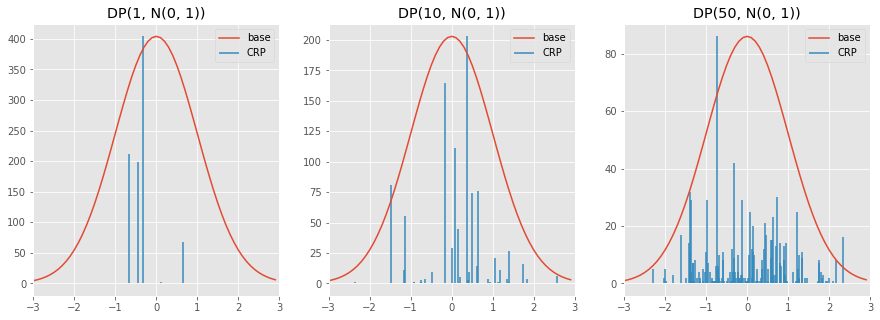

In [3]:
# Chinese Restaurant Process(CRP)
def chinese_restaurant_process(a, N=1000):
    D0 = sp.stats.norm
    tables = np.array([1, a])
    for n in np.arange(2, N+1):
        p = tables
        s = np.random.choice(tables.size, p=tables/(n-1+a))
        if(tables.size-1 == s):
            tables[s] = 1
            tables = np.append(tables, a)
        else:
            tables[s] += 1
    return D0.rvs(size=tables.size-1), tables[:-1]

a = np.array([1, 10, 50])
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, ax in enumerate(axes):
    v, p = chinese_restaurant_process(a[i])
    ax.vlines(v, [0], p, colors=colors[1], label='CRP')
    ax.set_xlim(-3, 3)
    ax.set_title(f"DP({a[i]}, N(0, 1))")  
    
    x = np.arange(-3.0, 3.0, 0.1)
    y = sp.stats.norm.pdf(x)
    y = y / y.max() * p.max()
    ax.plot(x, y, label='base')
    ax.legend()

In [4]:
a = 50
d = pd.DataFrame([])
for N in np.arange(100, 2600, 100):
    for _ in range(10):
        _, partions = chinese_restaurant_process(a, N)
        d = d.append(pd.DataFrame({'N': N, "K": len(partions)}, index=[0]), ignore_index=True)

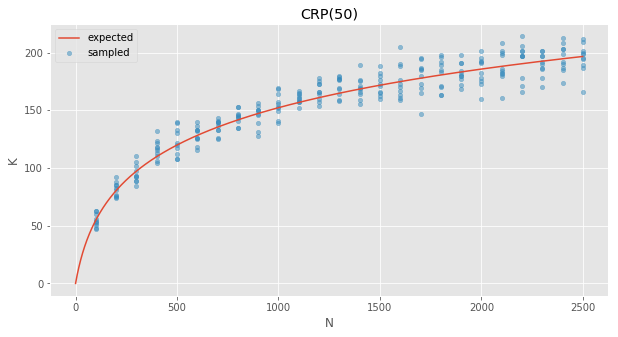

In [5]:
a = 50
ax = d.plot.scatter(x='N', y ='K', label='sampled', figsize=(10, 5), alpha=0.5)
x = np.arange(0, 2500)
y = a * np.log(1+x/a)
ax.plot(x, y, label='expected')
ax.set_title(f"CRP({a})")
ax.legend();

# ノンパラベイズをゼロから理解する.

## Dirichlet process とは何か?

確率分布を離散確率分布に変換することができる.

## 棒折り過程(stick breaking process)とは何か?

Dirichlet processの実装.

## 中華料理店過程(chinese restaurant process)とは何か?

## references

1. https://en.wikipedia.org/wiki/Stochastic_process
    - 確率過程とはそもそも何か?
1. https://docs.pymc.io/notebooks/dp_mix.html
    - コードと実例
        - numpyを駆使したコードは難しいが参考になる
    - CRPについて解説は無い
2. https://qiita.com/masasora/items/5469638d93d9c834724b
    - 参考文献がたくさｎ
    - コードが無い
3. https://en.wikipedia.org/wiki/Dirichlet_process
4. https://en.wikipedia.org/wiki/Chinese_restaurant_process